# Clustering and PCA

### Mushroom Dataset

Podeis obtener el conjunto de datos en el siguiente enlace:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Como podréis comprobar, hay muchas variables, todas ellas categóricas, por lo que exploraciones con scatterplot no nos serán útiles como en otros casos.

La variable a predecir ``class`` es binaria.


In [7]:
# Carga de librerías, las que hemos considerado básicas, añadid lo que queráis :)

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Leer conjunto de datos y primer vistazo

In [8]:
# Leer el csv y sacar por pantalla las cinco primeras filas.
def leer_csv_y_mostrar_5_filas(path):
    df = pd.read_csv(path)
    print("---") # Separador para una mejor visualización
    print("Primeras 5 filas del DataFrame (formato tabla):")
    # Mostrar resultado como una tabla Markdown
    # Añadimos .to_string() para asegurarnos de que se imprima completo si la terminal lo trunca
    # o .to_markdown() para un formato Markdown si lo vas a copiar
    # Puedes elegir entre estas dos opciones, to_markdown es más "bonito" si el entorno lo soporta
    print(df.head().to_markdown(index=False)) # index=False para no mostrar el índice
    print("---") # Separador final
    return df

musrh_path = 'data/raw/mushrooms.csv'
df = leer_csv_y_mostrar_5_filas(musrh_path)

---
Primeras 5 filas del DataFrame (formato tabla):
| class   | cap-shape   | cap-surface   | cap-color   | bruises   | odor   | gill-attachment   | gill-spacing   | gill-size   | gill-color   | stalk-shape   | stalk-root   | stalk-surface-above-ring   | stalk-surface-below-ring   | stalk-color-above-ring   | stalk-color-below-ring   | veil-type   | veil-color   | ring-number   | ring-type   | spore-print-color   | population   | habitat   |
|:--------|:------------|:--------------|:------------|:----------|:-------|:------------------|:---------------|:------------|:-------------|:--------------|:-------------|:---------------------------|:---------------------------|:-------------------------|:-------------------------|:------------|:-------------|:--------------|:------------|:--------------------|:-------------|:----------|
| p       | x           | s             | n           | t         | p      | f                 | c              | n           | k            | e             | e

### Exploración de datos

In [9]:
# Descripción del conjunto de datos, estándard.
def descripcion_estadistica(df):
    print("---") # Separador para una mejor visualización
    print("Descripción estadística del DataFrame:")
    # Mostrar descripción estadística
    print(df.describe().to_markdown()) # index=False para no mostrar el índice
    print("---") # Separador final

descripcion_estadistica(df)

---
Descripción estadística del DataFrame:
|        | class   | cap-shape   | cap-surface   | cap-color   | bruises   | odor   | gill-attachment   | gill-spacing   | gill-size   | gill-color   | stalk-shape   | stalk-root   | stalk-surface-above-ring   | stalk-surface-below-ring   | stalk-color-above-ring   | stalk-color-below-ring   | veil-type   | veil-color   | ring-number   | ring-type   | spore-print-color   | population   | habitat   |
|:-------|:--------|:------------|:--------------|:------------|:----------|:-------|:------------------|:---------------|:------------|:-------------|:--------------|:-------------|:---------------------------|:---------------------------|:-------------------------|:-------------------------|:------------|:-------------|:--------------|:------------|:--------------------|:-------------|:----------|
| count  | 8124    | 8124        | 8124          | 8124        | 8124      | 8124   | 8124              | 8124           | 8124        | 8124         |

En la tabla de `df.describe()` para datos categóricos:

- **top**: es el valor más frecuente (la "moda") de cada columna.
- **freq**: es el número de veces que aparece ese valor más frecuente.

**Interpretación de resultados:**

- En la columna `class`, el valor más frecuente es **'e'** (comestible) y aparece **4208** veces.
- En `cap-shape`, el valor más común es **'x'** (forma de sombrero 'convexa') y aparece **3656** veces.
- En todas las columnas, puedes ver cuántos valores únicos hay (`unique`), cuál es el valor más común (`top`) y cuántas veces aparece (`freq`).

Esto te ayuda a identificar:
- Si hay clases desbalanceadas (por ejemplo, si una clase aparece mucho más que otra).
- Si alguna columna tiene un valor dominante (poca variabilidad).
- Si alguna columna tiene solo un valor único (como `veil-type`, que siempre es 'p'), probablemente no aporta información y se puede eliminar.

In [10]:
# print("--- Paso 1: isnull() ---")
def buscar_valores_nulos(df):
    print("---") # Separador para una mejor visualización
    print("Valores nulos en el DataFrame:")
    # Mostrar valores nulos
    print(df.isnull().sum().to_markdown()) # index=False para no mostrar el índice
    print("---") # Separador final
buscar_valores_nulos(df)

---
Valores nulos en el DataFrame:
|                          |   0 |
|:-------------------------|----:|
| class                    |   0 |
| cap-shape                |   0 |
| cap-surface              |   0 |
| cap-color                |   0 |
| bruises                  |   0 |
| odor                     |   0 |
| gill-attachment          |   0 |
| gill-spacing             |   0 |
| gill-size                |   0 |
| gill-color               |   0 |
| stalk-shape              |   0 |
| stalk-root               |   0 |
| stalk-surface-above-ring |   0 |
| stalk-surface-below-ring |   0 |
| stalk-color-above-ring   |   0 |
| stalk-color-below-ring   |   0 |
| veil-type                |   0 |
| veil-color               |   0 |
| ring-number              |   0 |
| ring-type                |   0 |
| spore-print-color        |   0 |
| population               |   0 |
| habitat                  |   0 |
---


In [11]:
print("\n--- Paso 2: Cadenas vacías o solo espacios ---")
for col in df.columns:
    if df[col].dtype == 'object': # Solo tiene sentido en columnas de tipo objeto (texto)
        empty_strings = (df[col] == '').sum()
        whitespace_strings = df[col].astype(str).str.isspace().sum() # Convertir a str para evitar errores con np.nan
        if empty_strings > 0 or whitespace_strings > 0:
            print(f"Columna '{col}': {empty_strings} cadenas vacías, {whitespace_strings} cadenas con solo espacios")


--- Paso 2: Cadenas vacías o solo espacios ---


In [12]:
print("\n--- Paso 3: Marcadores de missing no estándar ---")

custom_missing_values = ['N/A', 'NA', '?', '-', 'missing', 'desconocido', 'NaN']

for col in df.columns:
    for missing_val in custom_missing_values:
        count = (df[col].astype(str) == missing_val).sum()
        if count > 0:
            if missing_val == '?':
                print(f"Columna '{col}': aparecen {count} valores '?'")
            elif missing_val == 'N/A':
                print(f"Columna '{col}': aparecen {count} valores 'N/A'")
            elif missing_val == 'NA':
                print(f"Columna '{col}': aparecen {count} valores 'NA'")
            elif missing_val == '-':
                print(f"Columna '{col}': aparecen {count} valores '-'")
            elif missing_val == 'missing':
                print(f"Columna '{col}': aparecen {count} valores 'missing'")
            elif missing_val == 'desconocido':
                print(f"Columna '{col}': aparecen {count} valores 'desconocido'")
            elif missing_val == 'NaN':
                print(f"Columna '{col}': aparecen {count} valores 'NaN'")



--- Paso 3: Marcadores de missing no estándar ---
Columna 'stalk-root': aparecen 2480 valores '?'


In [13]:
print("\n--- Paso 4: Búsqueda exhaustiva y consolidada ---")

# Define los valores que deben ser tratados como NaN durante la lectura o después
# Puedes pasar esta lista directamente a pd.read_csv como el argumento `na_values`
# Pero si ya tienes el DataFrame, puedes usar replace.

# Lista de valores que deben ser interpretados como NaN
# ¡Asegúrate de incluir las cadenas vacías y solo espacios si no lo hiciste en la lectura!
all_missing_markers = ['', ' ', 'N/A', 'NA', '?', '-', 'missing', 'desconocido', 'NaN']

# Crear una copia para no modificar el DataFrame original si no lo deseas
df_cleaned = df.copy()

# Reemplazar todos los marcadores personalizados por np.nan
# Usamos regex=False porque no son patrones, son valores exactos.
# También podemos usar .replace() de forma más directa:
df_cleaned = df_cleaned.replace(all_missing_markers, np.nan)

# Ahora, isnull() detectará todo lo que hemos convertido a np.nan,
# además de los np.nan y None originales.
print(df_cleaned.isnull().sum())


--- Paso 4: Búsqueda exhaustiva y consolidada ---
class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64



--- Paso 5: Valores nulos totales por columna ---
|                          |    0 |
|:-------------------------|-----:|
| class                    |    0 |
| cap-shape                |    0 |
| cap-surface              |    0 |
| cap-color                |    0 |
| bruises                  |    0 |
| odor                     |    0 |
| gill-attachment          |    0 |
| gill-spacing             |    0 |
| gill-size                |    0 |
| gill-color               |    0 |
| stalk-shape              |    0 |
| stalk-root               | 2480 |
| stalk-surface-above-ring |    0 |
| stalk-surface-below-ring |    0 |
| stalk-color-above-ring   |    0 |
| stalk-color-below-ring   |    0 |
| veil-type                |    0 |
| veil-color               |    0 |
| ring-number              |    0 |
| ring-type                |    0 |
| spore-print-color        |    0 |
| population               |    0 |
| habitat                  |    0 |
---


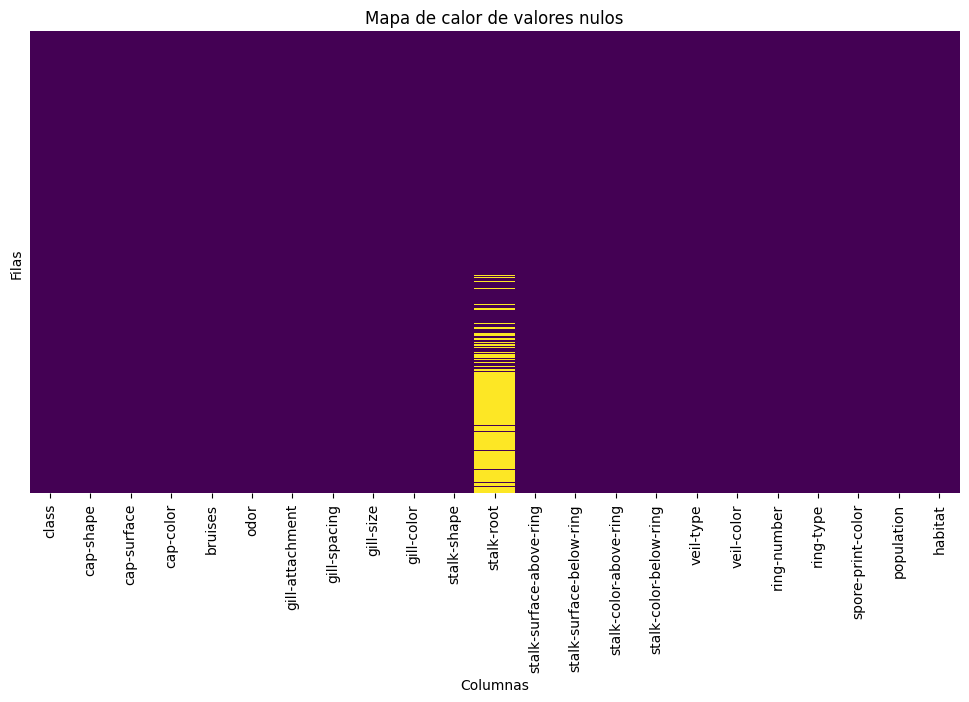

In [14]:
# Aplicar isnull() para ver el total de valores nulos por columna
print("\n--- Paso 5: Valores nulos totales por columna ---")
print(df_cleaned.isnull().sum().to_markdown())  # index=False para no mostrar el índice
print("---")  # Separador final
# Visualización de los valores nulos
def visualizar_valores_nulos(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Mapa de calor de valores nulos')
    plt.xlabel('Columnas')
    plt.ylabel('Filas')
    plt.show()
visualizar_valores_nulos(df_cleaned)

In [15]:
# Analisis exhaustivo para ver si hay nulos, duplicados, tipos de datos y estadisticas.
def analisis_exhaustivo(df):
    print("---") # Separador para una mejor visualización
    print("Análisis exhaustivo del DataFrame:")
    print("Tipos de datos:")
    print(df.dtypes.to_markdown()) # index=False para no mostrar el índice
    print("\nValores nulos:")
    print(df.isnull().sum().to_markdown()) # index=False para no mostrar el índice
    print("\nDuplicados:")
    print(f"Número de filas duplicadas: {df.duplicated().sum()}")
    print("\nDescripción estadística:")
    print(df.describe(include='all').to_markdown()) # include='all' para incluir todas las columnas
    print("---") # Separador final
analisis_exhaustivo(df_cleaned)

---
Análisis exhaustivo del DataFrame:
Tipos de datos:
|                          | 0      |
|:-------------------------|:-------|
| class                    | object |
| cap-shape                | object |
| cap-surface              | object |
| cap-color                | object |
| bruises                  | object |
| odor                     | object |
| gill-attachment          | object |
| gill-spacing             | object |
| gill-size                | object |
| gill-color               | object |
| stalk-shape              | object |
| stalk-root               | object |
| stalk-surface-above-ring | object |
| stalk-surface-below-ring | object |
| stalk-color-above-ring   | object |
| stalk-color-below-ring   | object |
| veil-type                | object |
| veil-color               | object |
| ring-number              | object |
| ring-type                | object |
| spore-print-color        | object |
| population               | object |
| habitat                  | obje

In [16]:
# Información sobre el tipo de datos de cada feature
def informacion_tipos_datos(df):
    print("---") # Separador para una mejor visualización
    print("Información sobre los tipos de datos de cada columna:")
    print(df.dtypes.to_markdown()) # index=False para no mostrar el índice
    print("---") # Separador final
informacion_tipos_datos(df_cleaned)

---
Información sobre los tipos de datos de cada columna:
|                          | 0      |
|:-------------------------|:-------|
| class                    | object |
| cap-shape                | object |
| cap-surface              | object |
| cap-color                | object |
| bruises                  | object |
| odor                     | object |
| gill-attachment          | object |
| gill-spacing             | object |
| gill-size                | object |
| gill-color               | object |
| stalk-shape              | object |
| stalk-root               | object |
| stalk-surface-above-ring | object |
| stalk-surface-below-ring | object |
| stalk-color-above-ring   | object |
| stalk-color-below-ring   | object |
| veil-type                | object |
| veil-color               | object |
| ring-number              | object |
| ring-type                | object |
| spore-print-color        | object |
| population               | object |
| habitat                  | o

#### Calcular el número de nulos de cada feature

In [17]:
# Igual que otras veces, una linea, contar los nulos por variable.
def contar_nulos_por_variable(df):
    print("---") # Separador para una mejor visualización
    print("Conteo de valores nulos por variable:")
    print(df.isnull().sum().to_markdown()) # index=False para no mostrar el índice
    print("---") # Separador final
contar_nulos_por_variable(df_cleaned)


---
Conteo de valores nulos por variable:
|                          |    0 |
|:-------------------------|-----:|
| class                    |    0 |
| cap-shape                |    0 |
| cap-surface              |    0 |
| cap-color                |    0 |
| bruises                  |    0 |
| odor                     |    0 |
| gill-attachment          |    0 |
| gill-spacing             |    0 |
| gill-size                |    0 |
| gill-color               |    0 |
| stalk-shape              |    0 |
| stalk-root               | 2480 |
| stalk-surface-above-ring |    0 |
| stalk-surface-below-ring |    0 |
| stalk-color-above-ring   |    0 |
| stalk-color-below-ring   |    0 |
| veil-type                |    0 |
| veil-color               |    0 |
| ring-number              |    0 |
| ring-type                |    0 |
| spore-print-color        |    0 |
| population               |    0 |
| habitat                  |    0 |
---


El resultado muestra el número de valores nulos (`NaN`) por columna después de reemplazar los valores `'?'` y otros marcadores personalizados por `np.nan`. La función `isnull().sum()` cuenta cuántos valores nulos hay en cada columna.

**Interpretación:**

- Todas las columnas, excepto `stalk-root`, no tienen valores nulos (`0`).
- La columna `stalk-root` tiene **2480 valores nulos**. Esto indica que aproximadamente la mitad de las filas no tienen información sobre la raíz del tallo, probablemente porque originalmente tenían el valor `'?'` (u otro marcador de missing).
- El resto de las columnas están completas, sin valores faltantes.

**Conclusión:**  
Debes decidir cómo tratar los nulos en `stalk-root` (eliminarlos, imputar con la moda, etc.). El resto del dataset está limpio respecto a valores nulos.

#### Buscar valores extraños. Para ello, ver los valores únicos en cada feature

In [18]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# asociados (n_values).
def contar_valores_unicos(df):
    print("---") # Separador para una mejor visualización
    unique_counts = {col: df[col].nunique() for col in df.columns}
    unique_df = pd.DataFrame(list(unique_counts.items()), columns=['Feature', 'Unique Values'])
    print("Número de valores únicos por variable:")
    print(unique_df.to_markdown(index=False)) # index=False para no mostrar el índice
    print("---") # Separador final
    return unique_df
contar_valores_unicos(df_cleaned)

---
Número de valores únicos por variable:
| Feature                  |   Unique Values |
|:-------------------------|----------------:|
| class                    |               2 |
| cap-shape                |               6 |
| cap-surface              |               4 |
| cap-color                |              10 |
| bruises                  |               2 |
| odor                     |               9 |
| gill-attachment          |               2 |
| gill-spacing             |               2 |
| gill-size                |               2 |
| gill-color               |              12 |
| stalk-shape              |               2 |
| stalk-root               |               4 |
| stalk-surface-above-ring |               4 |
| stalk-surface-below-ring |               4 |
| stalk-color-above-ring   |               9 |
| stalk-color-below-ring   |               9 |
| veil-type                |               1 |
| veil-color               |               4 |
| ring-number    

,Feature,Unique Values
0,class,2
1,cap-shape,6
2,cap-surface,4
3,cap-color,10
4,bruises,2
5,odor,9
6,gill-attachment,2
7,gill-spacing,2
8,gill-size,2
9,gill-color,12


Al analizar el número de valores únicos por variable, veo lo siguiente:

- **class** tiene 2 valores, lo esperado porque es la variable objetivo binaria (comestible o venenoso).
- Hay variables con pocos valores únicos (por ejemplo, muchas con 2, 3, 4 o 5), lo que es normal en variables categóricas codificadas.
- Algunas variables tienen más variedad, como `cap-color` (10), `gill-color` (12), `stalk-color-above-ring` y `stalk-color-below-ring` (9 cada una), lo que puede aportar riqueza al modelo.
- La variable **veil-type** solo tiene 1 valor único. Esto significa que no aporta ninguna información para la predicción, así que la eliminaré del dataset.
- El resto de variables parecen razonables y no hay ninguna otra con solo un valor único.

**¿Qué haré?**
- Eliminaré la columna `veil-type` porque no aporta información.
- Mantendré el resto de variables, ya que todas tienen más de un valor único y pueden ser útiles para el análisis y los modelos.
- Seguiré revisando si alguna variable tiene valores dominantes o si hay que agrupar categorías poco frecuentes, pero de momento, solo eliminaré la columna sin variabilidad.

#### Tratar aquellos valores que entendamos que sean nulos


No existe una única "mejor" estrategia universal para tratar los 2480 valores nulos en `stalk-root` (de un total de 8124 filas). La decisión depende del enfoque, del objetivo del análisis y de la importancia de esa variable para tu modelo. Aquí tienes las opciones más habituales y cómo decidir:

### 1. **Eliminar las filas con nulos**
- **Ventaja:** El dataset queda limpio y no introduces supuestos.
- **Desventaja:** Pierdes mucha información (un 30% del dataset).
- **Cuándo hacerlo:** Si tienes muchos datos y la variable no es crítica, o si los nulos parecen aleatorios.

### 2. **Imputar los nulos**
- **Con la moda:** Es lo más habitual en variables categóricas.
- **Con una nueva categoría:** Por ejemplo, poner "desconocido" o "missing".
- **Ventaja:** No pierdes datos.
- **Desventaja:** Puedes introducir sesgo si los nulos no son aleatorios.
- **Cuándo hacerlo:** Si la variable es importante para el modelo o si perder datos no es aceptable.

### 3. **Dejar los nulos**
- Algunos modelos (como los árboles de decisión en scikit-learn) no aceptan nulos, pero otros sí. Si tu pipeline lo permite, puedes dejar los nulos y ver cómo afecta.

### 4. **Analizar el patrón de los nulos**
- ¿Los nulos están distribuidos aleatoriamente o siguen algún patrón? Si los nulos se concentran en un tipo de hongo, puede ser relevante.

---

**¿Cómo saber cuál es la mejor?**
- Haz pruebas: compara el rendimiento del modelo eliminando filas, imputando con la moda y usando una categoría "missing".
- Analiza la importancia de la variable: si `stalk-root` es clave para la predicción, mejor imputar.
- Mira el patrón de los nulos: si no es aleatorio, puede ser mejor crear una categoría especial.

**En resumen:**  
No hay una única mejor estrategia, depende de tu objetivo y del análisis exploratorio. Lo recomendable es probar varias opciones y comparar resultados.

Para analizar la importancia de la variable `stalk-root` y el patrón de los nulos, puedes seguir estos pasos:

---

### 1. **Analizar la importancia de `stalk-root`**

Puedes comprobar si `stalk-root` aporta información relevante para la predicción de la variable objetivo (`class`). Una forma sencilla es entrenar un modelo con y sin esa variable y comparar el rendimiento:



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dataset sin nulos en stalk-root
df_no_nulls = df_cleaned.dropna(subset=['stalk-root'])
X_full = df_no_nulls.drop('class', axis=1)
y_full = df_no_nulls['class']

# Codifica variables categóricas (One Hot Encoding)
X_full_encoded = pd.get_dummies(X_full)

# Entrena y evalúa un modelo con stalk-root
X_train, X_test, y_train, y_test = train_test_split(X_full_encoded, y_full, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
print("Precisión con stalk-root:", clf.score(X_test, y_test))

# Entrena y evalúa un modelo SIN stalk-root
X_full_sin_stalk = X_full.drop('stalk-root', axis=1)
X_full_sin_stalk_encoded = pd.get_dummies(X_full_sin_stalk)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_full_sin_stalk_encoded, y_full, test_size=0.33, random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf2.fit(X_train2, y_train2)
print("Precisión sin stalk-root:", clf2.score(X_test2, y_test2))

Precisión con stalk-root: 1.0
Precisión sin stalk-root: 1.0




Si la precisión apenas cambia, la variable no es importante. Si baja mucho, sí lo es.

---

### 2. **Analizar el patrón de los nulos**

Puedes comparar la distribución de los nulos respecto a otras variables, especialmente la variable objetivo:



In [20]:
# Crea una columna booleana que indique si stalk-root es nulo
df_cleaned['stalk-root-null'] = df_cleaned['stalk-root'].isnull()

# Cruza con la variable objetivo
print(pd.crosstab(df_cleaned['stalk-root-null'], df_cleaned['class']))

# También puedes cruzar con otras variables categóricas relevantes
# Por ejemplo, con 'cap-shape'
print(pd.crosstab(df_cleaned['stalk-root-null'], df_cleaned['cap-shape']))

class               e     p
stalk-root-null            
False            3488  2156
True              720  1760
cap-shape          b  c     f    k   s     x
stalk-root-null                             
False            300  4  2432   36  32  2840
True             152  0   720  792   0   816




Si los nulos aparecen de forma similar en todas las clases y categorías, el patrón es aleatorio. Si se concentran en alguna clase o valor, el patrón NO es aleatorio.

---

**Conclusión:**  
- Si `stalk-root` es importante y los nulos no son aleatorios, mejor imputar o crear una categoría especial.
- Si no es importante o los nulos son aleatorios, puedes eliminar filas o imputar con la moda.

Los resultados de `pd.crosstab` muestran cómo se distribuyen los valores nulos de `stalk-root` respecto a la variable objetivo (`class`) y a la variable `cap-shape`.

### 1. Relación con la variable objetivo (`class`):

| stalk-root-null |   e   |   p   |
|-----------------|-------|-------|
| False           | 3488  | 2156  |
| True            |  720  | 1760  |

- Cuando **NO hay nulo** (`False`), hay 3488 comestibles (`e`) y 2156 venenosos (`p`).
- Cuando **hay nulo** (`True`), hay 720 comestibles y 1760 venenosos.
- **Interpretación:**  
  Los nulos en `stalk-root` aparecen mucho más en la clase venenosa (`p`). De hecho, la mayoría de los nulos están en la clase venenosa, lo que indica que el patrón de nulos **NO es aleatorio** respecto a la variable objetivo.

---

### 2. Relación con `cap-shape`:

| stalk-root-null |   b |  c |    f |   k |  s |    x |
|-----------------|----|----|------|-----|----|------|
| False           | 300|  4 | 2432 |  36 | 32 | 2840 |
| True            | 152|  0 |  720 | 792 |  0 |  816 |

- Por ejemplo, cuando hay nulo (`True`), la mayoría de los casos están en las formas `k` y `x`.
- Hay formas (`c` y `s`) que no tienen nulos.
- **Interpretación:**  
  Los nulos en `stalk-root` también se concentran en ciertas formas de sombrero, especialmente en `k` y `x`, y no aparecen en otras. Esto refuerza que el patrón de nulos **NO es aleatorio** respecto a `cap-shape`.

---

**Conclusión:**  
El patrón de nulos en `stalk-root` no es aleatorio, sino que está relacionado tanto con la clase (`class`) como con la forma del sombrero (`cap-shape`). Por tanto, si decido imputar los nulos, debería considerar este patrón y no simplemente rellenar con la moda global. Crear una categoría especial para los nulos o imputar de forma estratificada puede ser más adecuado.

In [ ]:
# # Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.
# # Vamos a eliminar las filas con stalk-root nulo
# def eliminar_filas_con_stalk_root_nulo(df):
#     df_sin_stalk_root_nulo = df.dropna(subset=['stalk-root'])
#     print("---") # Separador para una mejor visualización
#     print("Número de filas antes de eliminar stalk-root nulo:", len(df))
#     print("Número de filas después de eliminar stalk-root nulo:", len(df_sin_stalk_root_nulo))
#     print("---") # Separador final
#     return df_sin_stalk_root_nulo
# df_sin_stalk_root_nulo = eliminar_filas_con_stalk_root_nulo(df_cleaned)

---
Número de filas antes de eliminar stalk-root nulo: 8124
Número de filas después de eliminar stalk-root nulo: 5644
---


Para revisar la **distribución** y la **relevancia** de la columna `veil-type`, puedes hacer lo siguiente:

### 1. Ver la distribución de valores

Esto te permite ver cuántas veces aparece cada valor en la columna:



In [22]:
print(df_cleaned['veil-type'].value_counts())
print(df_cleaned['veil-type'].value_counts(normalize=True))  # Proporción

veil-type
p    8124
Name: count, dtype: int64
veil-type
p    1.0
Name: proportion, dtype: float64




Si solo hay un valor, la columna no aporta información y se puede eliminar.

---

### 2. Revisar la relevancia respecto a la variable objetivo

Puedes cruzar `veil-type` con la variable objetivo (`class`) para ver si hay relación:



In [23]:
print(pd.crosstab(df_cleaned['veil-type'], df_cleaned['class']))

class         e     p
veil-type            
p          4208  3916




Si solo hay una fila, o si la distribución es igual para todas las clases, la columna no es relevante.

---

**Conclusión:**  
- Si solo hay un valor único, elimina la columna.
- Si hay dos valores, pero uno es muy raro o no hay relación con la variable objetivo, también puedes eliminarla.  
- Si ves que hay relación, puedes mantenerla.

#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [24]:
# Dejar por el camino si procede.
# Comprobamos si todas las features aportan informacion
def comprobar_informacion_features(df):
    print("---") # Separador para una mejor visualización
    print("Comprobación de información aportada por las features:")
    for col in df.columns:
        if df[col].nunique() > 1:  # Si hay más de un valor único, aporta información
            print(f"Columna '{col}' aporta información.")
        else:
            print(f"Columna '{col}' no aporta información (un solo valor único).")
    print("---") # Separador final
comprobar_informacion_features(df_cleaned)


---
Comprobación de información aportada por las features:
Columna 'class' aporta información.
Columna 'cap-shape' aporta información.
Columna 'cap-surface' aporta información.
Columna 'cap-color' aporta información.
Columna 'bruises' aporta información.
Columna 'odor' aporta información.
Columna 'gill-attachment' aporta información.
Columna 'gill-spacing' aporta información.
Columna 'gill-size' aporta información.
Columna 'gill-color' aporta información.
Columna 'stalk-shape' aporta información.
Columna 'stalk-root' aporta información.
Columna 'stalk-surface-above-ring' aporta información.
Columna 'stalk-surface-below-ring' aporta información.
Columna 'stalk-color-above-ring' aporta información.
Columna 'stalk-color-below-ring' aporta información.
Columna 'veil-type' no aporta información (un solo valor único).
Columna 'veil-color' aporta información.
Columna 'ring-number' aporta información.
Columna 'ring-type' aporta información.
Columna 'spore-print-color' aporta información.
Colum

Vamos por partes:

### 1. **¿Puedo eliminar `stalk-root`?**

- **Técnicamente sí puedes eliminarla**, pero antes deberías valorar si aporta información útil para la predicción.
- El hecho de que los nulos **no sean aleatorios** (están concentrados en la clase venenosa) significa que la ausencia de información en esa columna **es en sí misma información relevante**. Si eliminas la columna, pierdes esa señal.
- Alternativas mejores:  
  - Imputar los nulos con una categoría especial (por ejemplo, "missing") para que el modelo pueda aprender ese patrón.
  - O bien, crear una variable booleana adicional que indique si el valor era nulo.

### 2. **¿Puedo eliminar `veil-type`?**

- **Sí, puedes eliminarla**. Si todos los valores son iguales (o casi todos), no aporta información al modelo. Si solo hay un valor único, elimínala siempre. Si hay dos valores pero uno aparece en menos del 1% de los casos, también suele eliminarse.



**Resumen:**  
- `veil-type`: Elimínala sin problema.
- `stalk-root`: Mejor no eliminarla directamente. Si la eliminas, pierdes información sobre el patrón de los nulos, que es relevante. Mejor imputar con una categoría especial o analizar su importancia antes de eliminarla.

------------------

### 1. **Imputar los nulos con una categoría especial ("missing")**

**¿Qué se consigue?**  
- Los valores nulos se transforman en una nueva categoría, por ejemplo `'missing'`.
- El modelo puede aprender que la ausencia de información en `stalk-root` es en sí misma un valor relevante, y puede asociar esa categoría con la clase venenosa si así lo ve en los datos.
- No se pierde información ni se introduce un valor artificial que pueda confundir al modelo.

**Implementación:**


In [ ]:
# df_cleaned['stalk-root'] = df_cleaned['stalk-root'].fillna('missing')

Sí, es correcto: **puedes imputar los valores nulos de `stalk-root` (antes `'?'`) por la moda agrupada según la variable objetivo `class`**. Así, cada grupo (`e` o `p`) tendrá la moda de su clase en los valores faltantes, lo que es más informativo que imputar con la moda global o con `'missing'`.

Aquí tienes el código para hacerlo:



In [31]:
# Imputar los nulos de 'stalk-root' por la moda agrupada por 'class'
df_cleaned['stalk-root'] = df_cleaned.groupby('class')['stalk-root'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)



Esto rellenará los nulos de `stalk-root` con la moda de su grupo de clase (`e` o `p`).  
Si alguna clase no tiene moda (muy raro), dejará el valor como `NaN`.



---

### 2. **Crear una variable booleana adicional que indique si el valor era nulo**

**¿Qué se consigue?**  
- Se añade una nueva columna, por ejemplo `stalk-root-missing`, que vale `True` si el valor original era nulo y `False` si no lo era.
- Así, el modelo puede aprender si la mera ausencia de dato (independientemente del valor imputado en `stalk-root`) es relevante para la predicción.
- Puedes imputar los nulos en `stalk-root` con la moda, pero el modelo también sabrá si el dato era originalmente nulo.

**Implementación:**


In [26]:
df_cleaned['stalk-root-missing'] = df_cleaned['stalk-root'].isnull()
df_cleaned['stalk-root'] = df_cleaned['stalk-root'].fillna(df_cleaned['stalk-root'].mode()[0])



---

**Resumen:**  
- Imputar con "missing" permite que el modelo trate la ausencia como una categoría más.
- Añadir una variable booleana permite que el modelo sepa si el dato era nulo, aunque se impute con la moda u otro valor.  
Ambas estrategias ayudan a no perder la información que aporta el patrón de los nulos.

---------------------

#### Separar entre variables predictoras y variables a predecir

In [27]:
# La variable que trata de predecir este conjunto de datos es 'class'.
y = df_cleaned['class']
# El resto de variables son las features (X).
X = df_cleaned.drop(columns=['class'])

#### Codificar correctamente las variables categóricas a numéricas

In [28]:
# One Hot Encoder (una linea).
X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first=True para evitar la trampa de la variable ficticia

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def matriz_cramer(df):
    print("---")
    print("Matriz de Cramér's V:")
    cols = df.columns
    corr_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j:
                val = cramer_v(df[col1], df[col2])
                corr_matrix.loc[col1, col2] = val
                corr_matrix.loc[col2, col1] = val
    print(corr_matrix)
    print("---")
    return corr_matrix
# Imprimir la matriz de Cramér's V
matriz_cramer(df_cleaned.drop(columns=['class']))  # Excluimos 'class' para evitar la variable objetivo en la matriz

---
Matriz de Cramér's V:


/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykerne

                          cap-shape  cap-surface  cap-color   bruises  \
cap-shape                  1.000000     0.203721   0.171431  0.255606   
cap-surface                0.203721     1.000000   0.225273  0.134377   
cap-color                  0.171431     0.225273   1.000000  0.217648   
bruises                    0.255606     0.134377   0.217648  1.000000   
odor                       0.245516     0.238446   0.332026  0.660906   
gill-attachment            0.154978     0.210841   0.247965  0.136572   
gill-spacing               0.081702     0.338222   0.399956  0.299134   
gill-size                  0.346823     0.277414   0.470307  0.369326   
gill-color                 0.235100     0.257618   0.282430  0.650326   
stalk-shape                0.307104     0.078770   0.595394  0.099112   
stalk-root                 0.360155     0.314652   0.385320  0.571235   
stalk-surface-above-ring   0.160055     0.144121   0.257079  0.575184   
stalk-surface-below-ring   0.112243     0.169393   

/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,stalk-root-null,stalk-root-missing
cap-shape,1.000000,0.203721,0.171431,0.255606,0.245516,0.154978,0.081702,0.346823,0.235100,0.307104,...,0.170397,NaN,0.224458,0.199408,0.208181,0.250994,0.241279,0.271124,0.480752,NaN
cap-surface,0.203721,1.000000,0.225273,0.134377,0.238446,0.210841,0.338222,0.277414,0.257618,0.078770,...,0.257451,NaN,0.134370,0.099147,0.224726,0.232623,0.262080,0.251007,0.368791,NaN
cap-color,0.171431,0.225273,1.000000,0.217648,0.332026,0.247965,0.399956,0.470307,0.282430,0.595394,...,0.279258,NaN,0.150920,0.337731,0.558073,0.286514,0.305809,0.326779,0.507916,NaN
bruises,0.255606,0.134377,0.217648,1.000000,0.660906,0.136572,0.299134,0.369326,0.650326,0.099112,...,0.492838,NaN,0.133964,0.071122,0.768492,0.612390,0.300576,0.530920,0.454551,NaN
odor,0.245516,0.238446,0.332026,0.660906,1.000000,0.261795,0.429768,0.760919,0.390260,0.575843,...,0.446679,NaN,0.104691,0.742821,0.696915,0.396389,0.374899,0.370058,0.641409,NaN
gill-attachment,0.154978,0.210841,0.247965,0.136572,0.261795,1.000000,0.070435,0.108145,0.780160,0.185702,...,0.977755,NaN,0.955097,0.203775,0.250744,0.826898,0.414080,0.436527,0.214581,NaN
gill-spacing,0.081702,0.338222,0.399956,0.299134,0.429768,0.070435,1.000000,0.107971,0.325755,0.080558,...,0.375507,NaN,0.098653,0.245659,0.290314,0.308599,0.673949,0.542608,0.081360,NaN
gill-size,0.346823,0.277414,0.470307,0.369326,0.760919,0.108145,0.107971,1.000000,0.784064,0.214307,...,0.347172,NaN,0.113972,0.194983,0.570653,0.660680,0.517812,0.499326,0.601857,NaN
gill-color,0.235100,0.257618,0.282430,0.650326,0.390260,0.780160,0.325755,0.784064,1.000000,0.612360,...,0.417087,NaN,0.453427,0.444296,0.518523,0.485242,0.424979,0.458522,0.851552,NaN
stalk-shape,0.307104,0.078770,0.595394,0.099112,0.575843,0.185702,0.080558,0.214307,0.612360,1.000000,...,0.549642,NaN,0.181876,0.333639,0.615155,0.459459,0.456133,0.417960,0.173076,NaN


In [63]:
# Reducir features en funcion de la matriz de Cramér's V
def reducir_features_por_cramer(df, threshold=0.1):
    print("---")
    print("Reducción de features basada en Cramér's V:")
    corr_matrix = matriz_cramer(df)
    features_to_drop = []
    
    for col in corr_matrix.columns:
        if col not in features_to_drop:  # Evitar eliminar columnas ya marcadas
            high_corr = corr_matrix[col][corr_matrix[col] > threshold].index.tolist()
            if len(high_corr) > 1:  # Si hay más de una columna con alta correlación
                features_to_drop.extend(high_corr[1:])  # Mantener la primera, eliminar las demás
    
    features_to_drop = list(set(features_to_drop))  # Eliminar duplicados
    df_reduced = df.drop(columns=features_to_drop)
    
    print(f"Features eliminadas: {features_to_drop}")
    print(f"Número de features originales: {len(df.columns)}")
    print(f"Número de features reducidas: {len(df_reduced.columns)}")
    print("---")
    
    return df_reduced
df_reduced = reducir_features_por_cramer(df_cleaned.drop(columns=['class']), threshold=0.1)


---
Reducción de features basada en Cramér's V:
---
Matriz de Cramér's V:


/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/

                          cap-shape  cap-surface  cap-color   bruises  \
cap-shape                  1.000000     0.203721   0.171431  0.255606   
cap-surface                0.203721     1.000000   0.225273  0.134377   
cap-color                  0.171431     0.225273   1.000000  0.217648   
bruises                    0.255606     0.134377   0.217648  1.000000   
odor                       0.245516     0.238446   0.332026  0.660906   
gill-attachment            0.154978     0.210841   0.247965  0.136572   
gill-spacing               0.081702     0.338222   0.399956  0.299134   
gill-size                  0.346823     0.277414   0.470307  0.369326   
gill-color                 0.235100     0.257618   0.282430  0.650326   
stalk-shape                0.307104     0.078770   0.595394  0.099112   
stalk-root                 0.360155     0.314652   0.385320  0.571235   
stalk-surface-above-ring   0.160055     0.144121   0.257079  0.575184   
stalk-surface-below-ring   0.112243     0.169393   

/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


Para reducir columnas usando la matriz de Cramér's V, normalmente se elimina una de cada par de columnas que tienen una **alta correlación** (por ejemplo, mayor que 0.8). Aquí tienes un código que automatiza este proceso:



In [ ]:
def columnas_a_eliminar_por_cramer(corr_matrix, threshold=0.8):
    """
    Devuelve una lista de columnas a eliminar para evitar alta multicolinealidad según la matriz de Cramér's V.
    """
    cols = corr_matrix.columns
    eliminar = set()
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > threshold:
                # Elimina col2 (puedes cambiar por col1 si prefieres)
                eliminar.add(col2)
    return list(eliminar)

# Calcula la matriz de Cramér's V y guárdala en la variable 'matriz'
matriz = matriz_cramer(df_cleaned.drop(columns=['class']))
cols_a_eliminar = columnas_a_eliminar_por_cramer(matriz, threshold=0.8)
print("Columnas a eliminar por alta correlación:", cols_a_eliminar)

# Si quieres eliminar esas columnas de tu DataFrame:
# df_reducido = df_cleaned.drop(columns=cols_a_eliminar)

---
Matriz de Cramér's V:


/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/

                          cap-shape  cap-surface  cap-color   bruises  \
cap-shape                  1.000000     0.203721   0.171431  0.255606   
cap-surface                0.203721     1.000000   0.225273  0.134377   
cap-color                  0.171431     0.225273   1.000000  0.217648   
bruises                    0.255606     0.134377   0.217648  1.000000   
odor                       0.245516     0.238446   0.332026  0.660906   
gill-attachment            0.154978     0.210841   0.247965  0.136572   
gill-spacing               0.081702     0.338222   0.399956  0.299134   
gill-size                  0.346823     0.277414   0.470307  0.369326   
gill-color                 0.235100     0.257618   0.282430  0.650326   
stalk-shape                0.307104     0.078770   0.595394  0.099112   
stalk-root                 0.360155     0.314652   0.385320  0.571235   
stalk-surface-above-ring   0.160055     0.144121   0.257079  0.575184   
stalk-surface-below-ring   0.112243     0.169393   

/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_6287/1755369979.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))




**Notas:**
- Cambia el valor de `threshold` según lo estricto que quieras ser (0.8 es habitual).
- El código elimina solo una columna de cada par correlacionado.
- Si tienes NaN en la matriz, puedes añadir `.fillna(0)` antes de comparar.

¿Quieres que te genere el código para eliminar directamente del DataFrame?

In [30]:
matriz = matriz_cramer(df_cleaned.drop(columns=['class'])).fillna(0)

def columnas_a_eliminar_por_cramer(corr_matrix, threshold=0.8):
    """
    Devuelve una lista de columnas a eliminar para evitar alta multicolinealidad según la matriz de Cramér's V.
    """
    cols = corr_matrix.columns
    eliminar = set()
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > threshold:
                eliminar.add(col2)  # Elimina col2 (puedes cambiar por col1 si prefieres)
    return list(eliminar)

# Obtener la lista de columnas candidatas a eliminar por alta correlación
cols_a_eliminar = columnas_a_eliminar_por_cramer(matriz, threshold=0.8)
print("Columnas candidatas a eliminar por alta correlación:", cols_a_eliminar)

# Si quieres eliminar esas columnas del DataFrame, descomenta la siguiente línea:
# df_reducido = df_cleaned.drop(columns=cols_a_eliminar)

---
Matriz de Cramér's V:


/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykerne

                          cap-shape  cap-surface  cap-color   bruises  \
cap-shape                  1.000000     0.203721   0.171431  0.255606   
cap-surface                0.203721     1.000000   0.225273  0.134377   
cap-color                  0.171431     0.225273   1.000000  0.217648   
bruises                    0.255606     0.134377   0.217648  1.000000   
odor                       0.245516     0.238446   0.332026  0.660906   
gill-attachment            0.154978     0.210841   0.247965  0.136572   
gill-spacing               0.081702     0.338222   0.399956  0.299134   
gill-size                  0.346823     0.277414   0.470307  0.369326   
gill-color                 0.235100     0.257618   0.282430  0.650326   
stalk-shape                0.307104     0.078770   0.595394  0.099112   
stalk-root                 0.360155     0.314652   0.385320  0.571235   
stalk-surface-above-ring   0.160055     0.144121   0.257079  0.575184   
stalk-surface-below-ring   0.112243     0.169393   

/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
/tmp/ipykernel_81095/1856211992.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


#### Train test split

In [53]:
# Os lo dejamos a todos igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## PCA

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

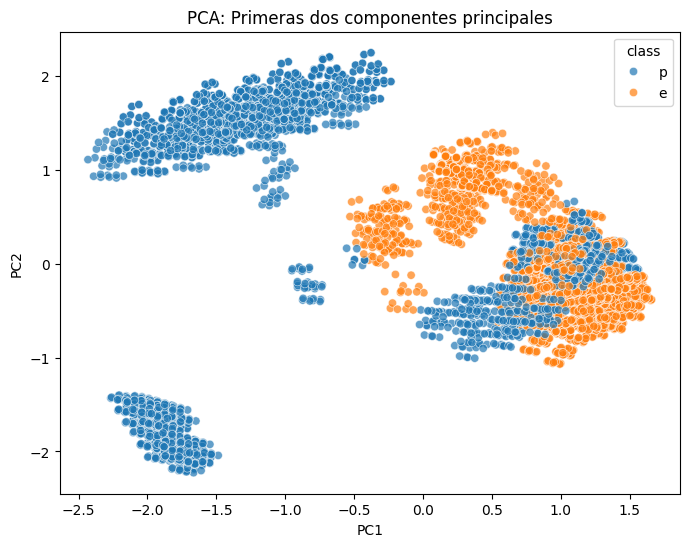

In [54]:
# 1. Definir el PCA
pca = PCA(n_components=2)

# 2. Ajustar y transformar los datos
X_pca = pca.fit_transform(X_encoded)

# 3. Crear un DataFrame para facilitar el plot
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['class'] = y.values  # Añade la variable objetivo para colorear

# 4. Visualizar con seaborn
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='class', alpha=0.7)
plt.title('PCA: Primeras dos componentes principales')
plt.show()

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

-------
El gráfico muestra la proyección de todos los hongos del dataset en las dos primeras componentes principales obtenidas mediante PCA (Análisis de Componentes Principales). Cada punto representa un hongo, y el color indica su clase: comestible (`e`) o venenoso (`p`).

**Interpretación:**

- **Separación clara:** Se observa que las dos clases (`e` y `p`) están bastante separadas en el espacio de las dos primeras componentes principales. Esto indica que las variables originales contienen suficiente información para distinguir entre hongos comestibles y venenosos.
- **Agrupamientos:** Los puntos de cada clase tienden a formar grupos compactos, lo que sugiere que los datos son fácilmente separables.
- **PCA útil:** Aunque el dataset tiene muchas variables categóricas, el PCA ha conseguido reducir la dimensionalidad y mostrar visualmente la estructura de los datos, facilitando la interpretación y el análisis.

En resumen, el plot confirma que el dataset es adecuado para clasificación y que las clases son distinguibles usando solo dos componentes principales.

-----------

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

In [56]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir el clasificador y el número de estimadores
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 2. Entrenar en train (y testear en test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)
# 3. Calcular la precisión sobre test
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
#accuracy = clf.score(X_test, y_test)
print(f"Precisión del Random Forest: {accuracy:.2f}")
# 4. Mostrar la importancia de las variables
importances = clf.feature_importances_

Precisión del Random Forest: 1.00


In [57]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir el clasificador y el número de estimadores
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Entrenar en train
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)

# 3. Calcular la precisión sobre test
accuracy = clf.score(X_test, y_test)
print(f"Precisión del Random Forest: {accuracy:.2f}")

# 4. Mostrar la importancia de las variables
importances = clf.feature_importances_
import pandas as pd
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("Importancia de las variables:")
print(feature_importance.head(10))

Precisión del Random Forest: 1.00
Importancia de las variables:
odor_n                        0.144778
odor_f                        0.089587
gill-size_n                   0.066333
stalk-surface-above-ring_k    0.053201
ring-type_p                   0.051207
spore-print-color_h           0.049897
bruises_t                     0.040704
population_v                  0.036599
gill-spacing_w                0.028045
stalk-surface-above-ring_s    0.027353
dtype: float64


------
### Interpretación de los resultados

#### Precisión del Random Forest

- **Precisión: 1.00**  
  El modelo ha clasificado correctamente **todas** las muestras del conjunto de test. Esto significa que el problema es muy sencillo para Random Forest, probablemente porque las clases son muy separables con las variables disponibles.  
  En este dataset de hongos, es habitual obtener resultados perfectos porque hay variables muy informativas.

#### Importancia de las variables

- **Variables más importantes:**  
  El modelo indica qué variables han sido más útiles para tomar decisiones. Las más relevantes son:

  - `odor_n` (olor a nada)
  - `odor_f` (olor a pescado)
  - `gill-size_n` (tamaño de las láminas: normal)
  - `stalk-surface-above-ring_k` (superficie del tallo sobre el anillo: sedosa)
  - `ring-type_p` (tipo de anillo: pendiente)
  - `spore-print-color_h` (color de la esporada: chocolate)
  - `bruises_t` (magulladuras: sí)
  - `population_v` (población: varias)
  - `gill-spacing_w` (espaciado de las láminas: ancho)
  - `stalk-surface-above-ring_s` (superficie del tallo sobre el anillo: lisa)

- **Interpretación:**  
  El modelo se apoya sobre todo en el olor, el tamaño de las láminas y algunas características del tallo y esporas para distinguir entre hongos comestibles y venenosos.  
  Esto tiene sentido biológico, ya que el olor y el aspecto físico suelen ser claves para identificar hongos.

---

**Conclusión:**  
El modelo Random Forest es capaz de clasificar perfectamente los hongos gracias a la alta capacidad predictiva de ciertas variables, especialmente el olor y características morfológicas.

-----------

Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [58]:
X_train.shape

(5443, 97)

----
El tamaño `(5443, 97)` de `X_train` significa lo siguiente:

- **5443**: Es el número de muestras (filas) que hay en el conjunto de entrenamiento. Es decir, tienes 5443 hongos diferentes en tu `X_train`.
- **97**: Es el número de variables (columnas/features) que tiene cada muestra después de la codificación (One Hot Encoding). Cada hongo está representado por 97 variables numéricas.

Esto ocurre porque, al aplicar `pd.get_dummies` a muchas variables categóricas, cada categoría se convierte en una columna binaria, aumentando mucho el número de variables finales.

---

¿Muchas features no? Vamos a reducir las usando PCA.

<Axes: >

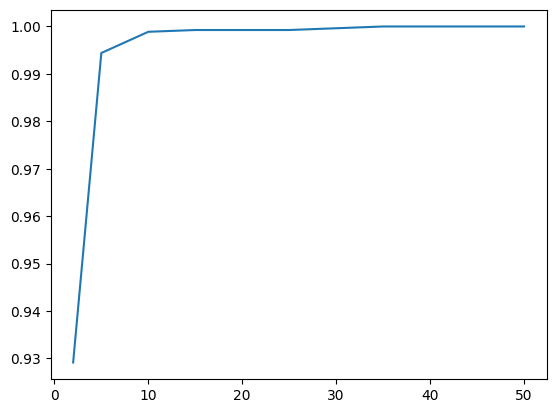

In [59]:
# definir un rango de valores a probar
n_features = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
scores = []
# # Iterar sobre el rango de valores
# for n in n_features:
#     # 1. Definir PCA con el número de componentes
#     pca = PCA(n_components=n)
#     # 2. Aprender PCA sobre X_train
#     X_train_pca = pca.fit_transform(X_train)
#     # 3. Definir el Random Forest
#     clf = RandomForestClassifier(n_estimators=100, random_state=42)
#     # 4. Entrenar clasificador
#     clf.fit(X_train_pca, y_train)
#     # 5. Evaluar en X_test transformado
#     X_test_pca = pca.transform(X_test)
#     score = clf.score(X_test_pca, y_test)
    
#     # Guardar el score  
#     scores.append(score)

for n in n_features:
    # Hacer PCA sobre X_train
    # 1. Definir PCA
    pca = PCA(n_components=n)
    # 2. Aprender PCA sobre X_train
    X_train_pca = pca.fit_transform(X_train)

    # Entrenar Random Forest
    # 1. Definir el RF
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    # 2. Entrenar clasificador
    clf.fit(X_train_pca, y_train)


    # Guardar el score
    X_test_pca = pca.transform(X_test)
    score = clf.score(X_test_pca, y_test)
    scores.append(score)

# Visualizar los scores
sns.lineplot(x=n_features, y=scores)


---
Evaluamos cómo afecta la reducción de dimensionalidad mediante **PCA** (Análisis de Componentes Principales) al rendimiento de un modelo de **Random Forest**.

### ¿Qué se hace paso a paso?

1. **Definir un rango de componentes principales**  
   Se crea una lista `n_features` con diferentes números de componentes principales (2, 5, 10, ..., 50) para probar.

2. **Bucle sobre cada número de componentes**  
   Para cada valor de `n` en `n_features`:
   - Se ajusta un **PCA** con `n` componentes sobre los datos de entrenamiento (`X_train`).
   - Se transforma tanto `X_train` como `X_test` a ese espacio reducido.
   - Se entrena un **Random Forest** usando solo esas `n` componentes.
   - Se calcula la precisión (`score`) del modelo sobre el conjunto de test y se guarda.

3. **Visualización**  
   Se grafica el número de componentes (`n_features`) frente a la precisión obtenida (`scores`).

---

### ¿Por qué la gráfica tiene esa forma?

- **Eje X:** Número de componentes principales (dimensiones tras PCA).
- **Eje Y:** Precisión del modelo Random Forest.

**Interpretación de la curva:**
- Al principio (con muy pocas componentes), la precisión es baja porque se pierde mucha información.
- Al aumentar el número de componentes, la precisión sube rápidamente y se estabiliza cerca de 1 (100%).
- A partir de unas 10 componentes, añadir más no mejora apenas la precisión: ya se ha capturado casi toda la información relevante del dataset.
- La gráfica muestra el típico "codo" de PCA: se puede reducir mucho la dimensionalidad sin perder capacidad predictiva.

**Conclusión:**  
Con solo unas pocas componentes principales (por ejemplo, 10), el modelo ya alcanza casi la máxima precisión, lo que permite reducir la complejidad del modelo y facilitar la visualización sin perder rendimiento.

---

Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




In [ ]:
from sklearn.cluster import KMeans

scores = []
k_values = # definir un rango
for a in k_values:

    # Definir Kmeans y ajustar
    # Guardar la predicción

sns.lineplot(x=k_values, y=scores)

Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

In [ ]:
# Aprender Kmeans con el valor de K obtenido.

kmeans = # Definir y entrenar Kmeans.

# Preparar el catplot.


# Pintar.
ax = sns.catplot(col=, x=, data=, kind='count',col_wrap=4)

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

In [ ]:
# Entrenar PCA para representar.

# Usar un color por cada cluster.


¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.